In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [84]:
class Datapoint:
    def __init__(self, coordinate, color, **kwargs):
        assert isinstance(coordinate, list), 'Coordinate must be a list of integers'
        assert isinstance(color, str)
        self.coordinate = coordinate
        self.color = color
        self.kwargs = kwargs

class Node:
    def __init__(self, weight = 0, children = 0, color=None, rect_1=None, rect_2=None, dp: Datapoint=None, **kwargs):
        self.left_rectangle: list[int] or None = rect_1
        self.right_rectangle: list[int] or None = rect_2
        self.datapoint: Datapoint or None = dp
        self.left_child: Node or None = None
        self.right_child: Node or None = None
        self.color: str or None = color
        self.weight = weight
        self.children = children
        self.kwargs = kwargs

class KDTree:
    def __init__(self):
        self.root: Node or None = None
        self.dimension: int = 0
        self.level1: dict[str: float] = dict()
        self.colors: dict[str: float] or None = None
    
    def __calculate_probs(self, weights: list[float]) -> list[float]:
        ai = list()
        for weight in weights:
            ai.append(self.__single_prob(weight))
        return ai
    
    def __single_prob(self, weight) -> float:
        return random.random() ** weight
    
    def __add_color(self, color: str):
        if color not in self.level1:
            self.level1[color] = self.__single_prob(self.colors[color])
            
    def level1_random_selection(self, rectangle: list) -> str:
        c_nodes = self.query_canonical(rectangle)
        weights = [self.level1[node.color] for node in c_nodes]
        index_max = np.argmax(weights)
        return c_nodes[index_max].color

    def build_tree(self, points: list[Datapoint], colors: dict[str: float]):
        assert len(points) > 0, 'There must be at least one datapoint to build tree'
        assert len(points[0].coordinate), 'The coordinate must have at least one dimension'
        self.dimension = len(points[0].coordinate)
        self.colors = colors
        self.root = self.__build_tree(points)

    def __build_tree(self, points: list[Datapoint]) -> Node or None:
        if len(points) == 0:
            return None
        if len(points) == 1:
            color_1 = points[0].color
            self.__add_color(color_1)
            return Node(dp=points[0], color=color_1, weight=self.colors[color_1])
        if len(points) == 2:
            points.sort(key=lambda pts: pts.coordinate)
            r_1 = [points[0].coordinate, points[0].coordinate]
            r_2 = [points[1].coordinate, points[1].coordinate]
            color_1 = points[0].color
            color_2 = points[1].color
            self.__add_color(color_1)
            self.__add_color(color_2)
            if self.level1[color_1] >= self.level1[color_2]:
                root_color = color_1
            else:
                root_color = color_2
            root = Node(rect_1=r_1, rect_2=r_2, color=root_color, children=2, weight=self.colors[color_1]+self.colors[color_2])
            root.left_child = Node(dp=points[0], color=color_1, weight=self.colors[color_1])
            root.right_child = Node(dp=points[1], color=color_2, weight=self.colors[color_2])
            return root

        coordinates = np.array([p.coordinate for p in points])
        variances = np.var(coordinates, axis=0)
        index_max_variance = np.argmax(variances)
        points.sort(key=lambda pts: pts.coordinate[index_max_variance])
        median_index = len(points) // 2
        root = Node(children=len(points))
        p1 = points[:median_index]
        p2 = points[median_index:]
        p1.sort(key=lambda pts: pts.coordinate)
        p2.sort(key=lambda pts: pts.coordinate)
        if p1[0].coordinate <= p2[0].coordinate:
            root.left_child = self.__build_tree(p1)
            root.right_child = self.__build_tree(p2)
        else:
            root.left_child = self.__build_tree(p2)
            root.right_child = self.__build_tree(p1)
        
        if root.right_child.datapoint is not None:
            r_1 = root.right_child.datapoint.coordinate
            root.right_rectangle = [r_1 , r_1]
        else:
            r_1 = root.right_child.left_rectangle[0]
            r_2 = root.right_child.right_rectangle[1]
            root.right_rectangle = [r_1, r_2]
            
        if root.left_child.datapoint is not None:
            r_1 = root.left_child.datapoint.coordinate
            root.left_rectangle = [r_1, r_1]
        else:
            r_1 = root.left_child.left_rectangle[0]
            r_2 = root.left_child.right_rectangle[1]
            root.left_rectangle = [r_1, r_2]  
        
        color_1 = root.left_child.color
        color_2 = root.right_child.color
        if self.level1[color_1] >= self.level1[color_2]:
            root_color = color_1
        else:
            root_color = color_2
        
        root.weight = self.colors[color_1] + self.colors[color_2]
        root.color = root_color
        return root
    
    def query_canonical(self, rectangle: list):
        assert len(rectangle) == 2, f'There must be two coordinates to draw a query rectangle'
        assert isinstance(rectangle[0], list) and isinstance(rectangle[0], list), 'Each coordinate must be in the format of a list'
        assert len(rectangle[0]) == self.dimension and len(rectangle[1]) == self.dimension, f'Expected dimension of rectangle to be {self.dimension}'
        assert rectangle[0] <= rectangle[1], 'Invalid query rectangle'
        return self.__query_canonical(self.root, rectangle)
    
    def __query_canonical(self, root: Node or None, query_rect: list) -> list[Node]:
        canonical_nodes : list[Node] = list()
        # If the node is None, return empty list. If the node is a leaf, return empty list
        if root is None or root.datapoint is not None:
            return canonical_nodes

        # If the node is outside the query range
        if query_rect[1] < root.left_rectangle[0] or query_rect[0] > root.right_rectangle[1]:
            return canonical_nodes
        
        # If the node is completely inside the query range, canonical node
        if query_rect[0] <= root.left_rectangle[0] and query_rect[1] >= root.right_rectangle[1]:
            canonical_nodes.append(root)
            return canonical_nodes
        
        # Check if the right node is a leaf
        if root.right_child.datapoint is not None:
            leaf = root.right_child
            if query_rect[0] <= leaf.datapoint.coordinate <= query_rect[1]:
                canonical_nodes.append(leaf)
        # Else check that the right node is in the query range
        elif root.right_rectangle[0] <= query_rect[0] <= root.right_rectangle[1] or root.right_rectangle[0] <= query_rect[1] <= root.right_rectangle[1]:
            canonical_nodes.extend(self.__query_canonical(root.right_child, query_rect))
        # Else check that the right node is completely inside the query range
        elif root.right_rectangle[0] >= query_rect[0] and root.right_rectangle[1] <= query_rect[1]:
            canonical_nodes.extend(self.__query_canonical(root.right_child, query_rect))
        
        # Check if left node is a leaf
        if root.left_child.datapoint is not None:
            leaf = root.left_child
            if query_rect[0] <= leaf.datapoint.coordinate <= query_rect[1]:
                canonical_nodes.append(leaf)
        # Else check that the left node is partially in the query range
        elif root.left_rectangle[0] <= query_rect[0] <= root.left_rectangle[1] or root.left_rectangle[0] <= query_rect[1] <= root.left_rectangle[1]:
            canonical_nodes.extend(self.__query_canonical(root.left_child, query_rect))
        # Else check that the left node is completely inside the query range
        elif root.left_rectangle[0] >= query_rect[0] and root.left_rectangle[1] <= query_rect[1]:
            canonical_nodes.extend(self.__query_canonical(root.left_child, query_rect))
                    
        return canonical_nodes
        
        

In [17]:
data_colors = {str(i): random.uniform(1,10) for i in range(1, 201)}

datapoints = [Datapoint([random.randint(1, 100), random.randint(1, 100)], color=random.choice( list(data_colors.keys()) ) ) for i in range(100)]

In [85]:
tree = KDTree()
tree.build_tree(datapoints, data_colors)
datapoints.sort(key=lambda pts: pts.coordinate)

In [91]:
c_nodes = tree.query_canonical( ([34, 56], [38, 3]) )
if len(c_nodes) > 0:
    for c in c_nodes:
        if c.datapoint is not None:
            print('leaf: ', c.datapoint.coordinate, c.children, c.color, tree.level1[c.color])
        else:
            print('node: ', c.left_rectangle, c.right_rectangle, c.children, c.color, tree.level1[c.color])
else:
    print('Empty')

leaf:  [36, 72] 0 13 1.1090680466298403e-05
leaf:  [34, 56] 0 157 0.25916960850804405
node:  [[35, 7], [35, 13]] [[38, 3], [38, 3]] 3 59 0.03993489868616407
node:  [[36, 40], [36, 40]] [[37, 39], [37, 39]] 2 57 0.3676142335997516
leaf:  [35, 42] 0 126 0.12980071554402647


In [94]:
test = tree.level1_random_selection(([34, 56], [38, 3]))
if test.datapoint is not None:
    print(test.datapoint.coordinate, test.color, data_colors[test.color])
else:
    print(test.left_rectangle, test.right_rectangle, test.color, data_colors[test.color])

[[35, 7], [35, 13]] [[38, 3], [38, 3]] 59 4.391023635786173


In [47]:
for datapoint in datapoints:
    print(datapoint.coordinate)

[2, 50]
[2, 62]
[4, 99]
[7, 25]
[7, 50]
[8, 98]
[9, 46]
[10, 90]
[11, 39]
[13, 10]
[13, 93]
[14, 84]
[15, 62]
[16, 42]
[16, 51]
[16, 52]
[16, 62]
[16, 69]
[17, 96]
[18, 38]
[18, 70]
[19, 23]
[19, 39]
[20, 1]
[20, 62]
[23, 36]
[23, 56]
[27, 98]
[28, 21]
[28, 45]
[28, 81]
[29, 58]
[29, 64]
[29, 67]
[30, 28]
[30, 90]
[30, 95]
[30, 98]
[32, 10]
[32, 36]
[33, 90]
[34, 56]
[35, 7]
[35, 13]
[35, 42]
[36, 40]
[36, 72]
[37, 39]
[38, 3]
[38, 74]
[39, 31]
[39, 94]
[42, 46]
[48, 31]
[48, 86]
[49, 59]
[50, 65]
[51, 13]
[52, 5]
[54, 92]
[56, 85]
[56, 96]
[59, 76]
[62, 16]
[65, 15]
[65, 82]
[65, 95]
[68, 60]
[69, 22]
[69, 25]
[70, 43]
[72, 60]
[72, 81]
[73, 26]
[74, 69]
[74, 92]
[75, 4]
[75, 98]
[76, 54]
[76, 73]
[78, 48]
[78, 64]
[80, 16]
[80, 39]
[81, 53]
[85, 16]
[85, 35]
[86, 13]
[86, 37]
[88, 8]
[88, 21]
[89, 28]
[93, 39]
[93, 61]
[94, 46]
[95, 69]
[96, 30]
[96, 89]
[97, 54]
[99, 100]


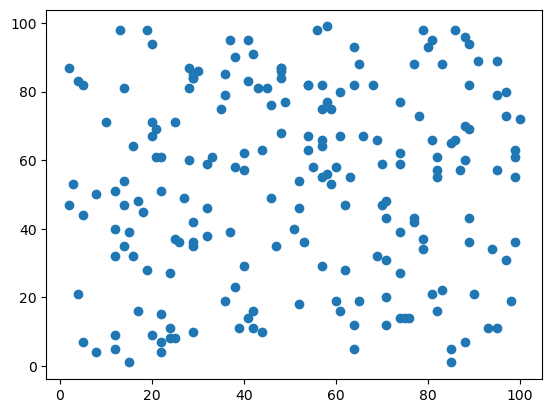

In [7]:
# Let's say we have the following list of coordinates:
crds = [dp.coordinate for dp in datapoints]

# We can separate these into two lists of x and y coordinates using the zip function:
x, y = zip(*crds)

# Now we can create a scatter plot of these coordinates:
plt.scatter(x, y)

# And finally display the plot:
plt.show()


In [8]:
def is_balanced(root):
    def check(node):
        if node is None:
            return 0
        left = check(node.left_child)
        right = check(node.right_child)
        if left == -1 or right == -1 or abs(left - right) > 1:
            return -1
        return 1 + max(left, right)

    return check(root) != -1

is_balanced(tree.root)

True